# MDI 230 - Projet Velib 
Priam CARDOUAT, Célia DOCLOT, Nicolas WITTMANN

## Initialisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
P = np.array([[0, 0.22, 0.32, 0.2, 0.26],
              [0.17, 0, 0.34, 0.21, 0.28], 
              [0.19, 0.26, 0, 0.24, 0.31], 
              [0.17, 0.22, 0.33, 0, 0.28], 
              [0.18, 0.24, 0.35, 0.23, 0]])

#On passe tout en seconde
Lambda = np.array([2.8, 3.7, 5.5, 3.5, 4.6])/3600

tau = np.array([[0, 3, 5, 7, 7],
                [2, 0, 2, 5, 5], 
                [4, 2, 0, 3, 3], 
                [8, 6, 4, 0, 2], 
                [7, 7, 5, 2, 0]])*60

# Conditions initiales
n_i_0 = np.array([20, 15, 17, 13, 18])

n_tijj_0 = np.array([[0, 1, 0, 0, 0],
                    [1, 0, 1, 0, 0], 
                    [0, 1, 0, 1, 0], 
                    [0, 0, 1, 0, 1], 
                    [0, 0, 0, 1, 0]])
etat_1 = np.diag(n_i_0) + n_tijj_0

## Simulation

### Q3

In [3]:
@jit
def determine_etat(etats, lambda_tot):
    """
    Cette fonction permet de determiner quel changement a eu lieu parmi tous les changements possibles. 
    Tous les changements suivent une loi exponentielle donc le prochain évènement suit une loi exponentielle 
    de paramètre la somme des paramètres des évènements possibles (lambda_tot). Pour déterminer lequel a eu lieu 
    on utilise le fait que la probabilité que l'évènement i de paramètre lambda_i soit celui qui a eu lieu est 
    lambda_i / lambda_tot avec somme des lambda_i = lambda_tot.
    
    
    Input : 
    - etats : np.array de shape 5x5 qui représente le nombre de vélos par endroit 
                en i,i il y a le nombre de vélos dans la station i et en i,j 
                le nombre de vélos en route pour la station j depuis la i
    - lambda_tot : le paramètre selon lequel on a tiré t, l'instant du prochain changement d'état
    
    Output : 
    - tuple de taille 4 : les deux premiers désignent la case de la matrice dont part le vélo et les deux derniers 
    ceux où va le vélo.
    """
    
    tirage = np.random.random()
    p = 0
    #On commence par les évènements "départ d'une station i vers j"
    #Ils suivent une loi exponentielle de paramètre lambda_i * p_ij s'il y a un véli dans la station i 
    for j in range(5):
        for i in range(5):
            if i != j:
                p += Lambda[i]*P[i][j]*(etats[i][i] > 0)
                if p/lambda_tot > tirage:
                      return i, i, i, j
                    
    #Ensuite il y a les évènements "un vélo se gare dans la station j après être parti de i"
    #Ces évènements dépendent du nombre de vélos en trajet de i vers j : ils suivent tous une loi de 
    #paramètre 1/tau_ij mais on s'intéresse au minimum dont le paramètres est donc etats[i][j]/tau[i][j]
    for j in range(5):
        for i in range(5):
            if i != j:
                p += etats[i][j]/tau[i][j]
                if p/lambda_tot > tirage:
                      return i, j, j, j

@jit
def simulation(etat_0, t_f):
    """
    Cette fonction simule l'évolution du nombre de vélos dans les stations et entre les stations dans le temps
    dans le cadre de notre modélisation du fonctionnement du Vélib à Rennes.
    
    Input : 
    - etat_0 : position initiale des vélos, détermine aussi le nombre de vélos dans le système
                np.array de shape 5x5 qui représente le nombre de vélos par endroit 
                en i,i il y a le nombre de vélos dans la station i et en i,j 
                le nombre de vélos en route pour la station j depuis la i
    - t_f : durée de la simulation en seconde 
    
    Output : 
    - evolution : la liste des matrices d'état au cours du temps
    - T : les instants auxquels correspondent les changements
    """
    
    etats = etat_0.copy()
    t = 0
    T = [0]
    evolution = [etats]
    
    while (t < t_f):
        #lambda_tot est le paramètre de la loi exponentielle décrivant le moment du prochain changement d'état
        lambda_tot = 0  
        for i in range(5):
            for j in range(5):
                if i != j:
                    #Evènement départ de la station i pour la station j, nécessite la présence de vélo en i
                    lambda_tot += Lambda[i]*P[i][j]*(etats[i][i] > 0)
                    
                    #Evènement arrivée en j depuis la station i, la loi est le minimum de toutes les lois suivient 
                    #par les vélos en chemin 
                    lambda_tot += etats[i][j]/tau[i][j]
        
        #Temps entre le dernier changement d'état et le nouveau 
        temps = np.random.exponential(1/lambda_tot)
        if temps > t_f :
            break
        t += temps
        T.append(t)
        # Mise à jour des états
        i0, j0, i1, j1 = determine_etat(etats, lambda_tot) #On choisit l'état qui change
        etats[i0][j0] -= 1 #on fait les transitions
        etats[i1][j1] += 1
        etats_bis = etats.copy()
        evolution += [etats_bis]
        
    return evolution, T


#On crée le graph en ne gardant que le nombre de vélos par station car on ne peux pas afficher 
#25 courbes sur le même graph
def graph_simu(evolution, T):
    for k in range(5):
        plt.plot(T,[state[k][k] for state in evolution], label="Station "+str(3+k))
    plt.legend(loc="best")
    plt.show()

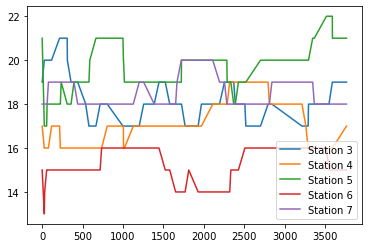

In [4]:
#On teste pour 1heure = 3600s : 
e,t = simulation(etat_1, 3600) 
graph_simu(e,t)

## Q4 et 5

In [5]:
def stations_vides(nb_iterations, etat_0, t_f, beta = 1.96, print_results = True): 
    """
    Cette fonction calcule la probabilité qu'une station soit vide à t_f avec son intervalle de confiance. On considère 
    que t_f est assez grand pour atteindre le régime stationnaire et que etat_0 n'aura pas de réel impact sur la distribution
    finale en dehors du fait qu'il fixe le nombre de vélos dans la simulation.
    
    Input : 
    - nb_iterations : nombre de simulations qu'on fait pour estimer la probabilité
    - etat_0 : état initial pour les simulations 
    - t_f : heure de fin de la simulation instant auquel on estime si la station est vide ou non
    - beta : coefficient multiplicateur correspondant au pourcentage de certitude que l'on cherche
             par défaut = 1.96 ce qui correspond à 95%
    - print_results : booleen qui demande si on veut print les intervalles ou juste avoir les probabilités
    
    Output : 
    - compt : les probabilités par stations qu'elles soient vide à t_f 
    """
    
    compt = [0] * 5
    for i in range(nb_iterations):
        etat_final = simulation(etat_0, t_f)[0][-1]
        for k in range(5):
            #On regarde si la station est vide à t_f
            if np.diag(etat_final)[k] == 0:
                compt[k] += 1 #Si c'est le cas on incrémente le compteur 

    for k in range(5):
        compt[k] /= nb_iterations
        compt = np.array(compt)
        
    ecart_type = np.sqrt(nb_iterations*(compt-compt**2)/(nb_iterations-1))
    
    marge = beta * ecart_type/np.sqrt(nb_iterations)
    
    if print_results : 
        for i in range(5):
            print("Probabilité que la station %i soit vide au bout de %i h : [ %f +- %f ]"%(i+3, t_f//3600, compt[i], marge[i]))
    
    return compt, marge 

In [6]:
c, m = stations_vides(100, etat_1, 150*3600)

Probabilité que la station 3 soit vide au bout de 150 h : [ 0.010000 +- 0.019600 ]
Probabilité que la station 4 soit vide au bout de 150 h : [ 0.040000 +- 0.038601 ]
Probabilité que la station 5 soit vide au bout de 150 h : [ 0.170000 +- 0.073995 ]
Probabilité que la station 6 soit vide au bout de 150 h : [ 0.060000 +- 0.046782 ]
Probabilité que la station 7 soit vide au bout de 150 h : [ 0.100000 +- 0.059096 ]


## Calcul Théorique

### Q6 

Soit $E = \{0, 1, 2, 3, 4, t_{01}, t_{02}... \}$ et $G = \{0, 1, 2, 3, 4\}$, les équations de traffic sont : 
$
\left\{
    \begin{array}{ll}
        \forall j \in E, \alpha_j > 0 \\
        \sum_{j\in E} \alpha_j = 1 \\
        \forall j \in E, \alpha_j \sum_{k \in E} \lambda_{jk} = \sum_{k\in E} \alpha_k \lambda_{kj}
    \end{array}
\right.
$

Mais on sait : 

Si $k$ est un trajet $\lambda_{jk} = 0$ si $j$ n'est pas le point de départ du trajet, sinon $\lambda_{jk} = p_{jk}\lambda_j$ avec les notations des consignes.
Si $k$ est une station alors $\lambda_{jk} = 0$ si $j$ n'est pas un trajet à destination de $k$, sinon $\lambda_{jk} = 1/\tau_{j}$ avec $j$ représentant départ et arrivée.

Donc on peut simplifier avec : 

$
\left\{
    \begin{array}{ll}
        \forall j \in E, \alpha_j > 0 \\
        \sum_{j\in E} \alpha_j = 1 \\
        \forall j \in G, \alpha_j \sum_{k\in G \\ k\neq j}\lambda_{j,t_{j,k}} = \sum_{k\in G \\ k\neq j} \alpha_{t_{kj}}\lambda_{t_{kj}, j} \\
        \forall i,j \in G, i\neq j, \alpha_{t_{ij}} \lambda_{t_{ij}, j} = \alpha_i \lambda_{i, t_{ij}}
    \end{array}
\right.
$

En remplaçant par les valeurs données ci-dessus on obtient : 

$
\left\{
    \begin{array}{ll}
        \forall j \in E, \alpha_j > 0 \\
        \sum_{j\in E} \alpha_j = 1 \\
        \forall j \in G, \alpha_j \lambda_j \sum_{k\in G \\ k\neq j} p_{jk} = \alpha_j \lambda_j = \sum_{k\in G \\ k\neq j} \alpha_{t_{kj}} / \tau_{kj} \\
        \forall j,k \in G, k\neq j, \alpha_{t_{jk}} / \tau_{jk} = \alpha_j p_{jk} \lambda_j
    \end{array}
\right.
$

On peut remplacer les $\alpha_{t_{kj}} / \tau_{kj}$ de la 3ème équation par ceux de la 4ème. On obtient : 

$\forall j \in G, \alpha_j \lambda_j = \sum_{k\in G \\ k\neq j} \alpha_k p_{kj} \lambda_k$ (1)

Avec la deuxième équation on peut donc conclure : 

$\sum_{j \in G} (\alpha_j + \sum_{k\in G \\ k\neq j}\alpha_{t_{jk}}) = \sum_{j \in G} \alpha_j (1 + \sum_{k\in G \\ k\neq j}p_{jk}\lambda_j \tau_{jk}) = 1$ (2)

L'équation (1) peut se mettre sous forme matricielle ce qui nous donne un espace vectoriel dont on ne garde que l'élément satisfaisant la condition (2).
______________

(1) <=> \begin{pmatrix}
  -\lambda0 & p_{10}\lambda_1 & p_{20}\lambda_2 & p_{30}\lambda_3 & p_{40}\lambda_4 \\
  p_{01}\lambda_0 & -\lambda_1 & p_{21}\lambda_2 & p_{31}\lambda_3 & p_{41}\lambda_4 \\
  p_{02}\lambda_0 &  p_{12}\lambda_2 &-\lambda_2 & p_{32}\lambda_3 & p_{42}\lambda_4 \\
  p_{03}\lambda_0 & p_{13}\lambda_1 & p_{23}\lambda_2 & -\lambda_3 & p_{43}\lambda_4 \\
  p_{04}\lambda_0  & p_{14}\lambda_1 & p_{24}\lambda_2 & p_{34}\lambda_3 & -\lambda_4\\
\end{pmatrix} * \begin{pmatrix}
\alpha_0 \\
\alpha_1 \\
\alpha_2 \\
\alpha_3 \\
\alpha_4 \\
\end{pmatrix} = 
\begin{pmatrix}
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 
\end{pmatrix}

______________

(2) <=> \begin{pmatrix}
  1 + \lambda_0 \sum_{k\in G \\ k\neq 0}p_{0k} \tau_{0k} & 
  1 + \lambda_1 \sum_{k\in G \\ k\neq 1}p_{1k} \tau_{1k} & 
  1 + \lambda_2 \sum_{k\in G \\ k\neq 2}p_{2k} \tau_{2k} & 
  1 + \lambda_3 \sum_{k\in G \\ k\neq 3}p_{3k} \tau_{3k} & 
  1 + \lambda_4 \sum_{k\in G \\ k\neq 4}p_{4k} \tau_{4k} \\
\end{pmatrix} * \begin{pmatrix}
\alpha_0 \\
\alpha_1 \\
\alpha_2 \\
\alpha_3 \\
\alpha_4 \\
\end{pmatrix} = 
\begin{pmatrix}
1 \\ 
\end{pmatrix}

Maintenant on résoud numériquement : 

In [7]:
M = np.diag(-Lambda) + P*Lambda
e, v = np.linalg.eig(M)
ker = v.T[np.where(e < 10**(-10))[0][0]]

$(\alpha_i)_{i\in G}$ est donc de la forme c * ker avec c satisfaisant la condition (2).

In [8]:
cond2 = np.sum(P*tau, axis = 0) * Lambda + np.ones(5)
c = cond2.dot(ker)
alphas = ker / c

In [9]:
alphas

array([0.21358044, 0.16162844, 0.10873186, 0.17086435, 0.13000549])

Avec ceux-ci, nous pouvons aisément retrouver les 20 derniers avec $\forall j,k \in G, k\neq j, \alpha_{t_{jk}} = \tau_{jk} \alpha_j p_{jk} \lambda_j$

In [10]:
alphas_restants = [alphas*Lambda[i] * (P*tau)[i] for i in range(len(Lambda))]
alphas_fin = np.diag(alphas) + alphas_restants 

In [11]:
np.sum(alphas_fin)

1.0004531583304235

### Q7 

Dans notre modélisation nous avons $S^2$ coloniées avec $S$ le nombre de stations, ce qui fait donc ici 25 colonies. Nous avons exactement 1 Vélib qui est toujours dans une de ces colonies et qui peut aller dans chacune d'entre elles. Il y a donc 25 états possibles qui sont les vecteurs $e_i = (0, 0, ..., 1, 0, ..., 0, 0)$ de longueur 25 et avec le $1$ en position $i \in \{1, 2, ..., 25\}$.  
**L'espace d'état est de dimension 25.**

### Q8

La probabilité qu'une station i soit vide dans l'état final/d'équilibre est $1 - \mathbb P(i \neq 0) = 1 - \mathbb P(i = 1) = 1 - \alpha[i]$

In [12]:
for i in range(len(alphas)): 
    print("La probabilité que la station %i soit vide est de %f" %(i+3, 1-alphas[i]))

La probabilité que la station 3 soit vide est de 0.786420
La probabilité que la station 4 soit vide est de 0.838372
La probabilité que la station 5 soit vide est de 0.891268
La probabilité que la station 6 soit vide est de 0.829136
La probabilité que la station 7 soit vide est de 0.869995


### Q9 

On réutilise la fonction simulation avec un état initial ne contenant qu'un vélo.

In [13]:
etat_2 = np.zeros((5,5))
etat_2[0][0] = 1
c,m = stations_vides(1000, etat_2, 150*3600)

Probabilité que la station 3 soit vide au bout de 150 h : [ 0.968000 +- 0.010914 ]
Probabilité que la station 4 soit vide au bout de 150 h : [ 0.959000 +- 0.012296 ]
Probabilité que la station 5 soit vide au bout de 150 h : [ 0.947000 +- 0.013893 ]
Probabilité que la station 6 soit vide au bout de 150 h : [ 0.951000 +- 0.013386 ]
Probabilité que la station 7 soit vide au bout de 150 h : [ 0.954000 +- 0.012991 ]


## Simulation pour 100 vélos 

### Q10

In [14]:
etat_3 = np.ones((5,5))*4
c,m = stations_vides(100, etat_3, 150*3600)

Probabilité que la station 3 soit vide au bout de 150 h : [ 0.020000 +- 0.027578 ]
Probabilité que la station 4 soit vide au bout de 150 h : [ 0.030000 +- 0.033604 ]
Probabilité que la station 5 soit vide au bout de 150 h : [ 0.170000 +- 0.073995 ]
Probabilité que la station 6 soit vide au bout de 150 h : [ 0.020000 +- 0.027578 ]
Probabilité que la station 7 soit vide au bout de 150 h : [ 0.080000 +- 0.053441 ]


Les probabilités sont beaucoup plus faibles car il y a beaucoup plus de vélos.

### Q11

Pour étudier le régime stationnaire dans le cas de 100 vélos nous allons étudier la simulation sur longtemps et nous allons étudier les boucles de celle-ci, c'est-à-dire en combien de temps et en passant par quoi la simulation revient à son point de départ.

In [15]:
@jit
def cycles(ev, n) : 
    """
    Cette fonction cherche à établir, parmi les n premiers états de ev, lequel est le plus réccurent.
    
    Input : 
    - ev : liste de matrices décrivant l'état du système, output de simulation
    - n : nombre d'état dont on étudie la récurrence
    
    Output : 
    - cycle : indices de l'état le plus récurrent de ev
    """

    taille_max = 2
    cycle = []
    for i in range(n) : 
        c = []
        for j in range(len(ev)):
            if (ev[j] == ev[i]).all() : #l'état i et j sont parfaitement identiques
                c.append(j)
        if len(c)>= taille_max : 
            cycle = c.copy()
            taille_max = len(c)
    return cycle

In [16]:
def simu_regenerative(etat_0, t_f, n_cycle, print_results = True) : 
    """
    Cette fonction cherche les probabilités stationnaires que chaque station soit vide. Pour cela, on utilise les simulations
    régénératives en sommant, pour la station i, les probabilités des états dont la station i est vide. 
    
    Input : 
    - etat_0 : matrice d'état initial, la répartition compte peu mais le nombre de vélos dans la simulation (défini
               par etat_0) est important
    - t_f : la longueur de la simulation qui nous permettra de trouver les cycles
    - n_cycle : paramètre n de la fonction cycles, entier
    - print_result : booléen qui détermine si on veut que les résultats ou si on veut les print avec détails
    
    Output :
    - moy : liste des probabilités que les stations soient vides
    - marge : nombre à ajouter et à soustraire à moy pour avoir l'intervalle de confiance à 95% de l'estimation
    """
    
    evolution, _ = simulation(etat_0, t_f)
    cycle = cycles(evolution, n_cycle)
    R = len(cycle) - 1
    print("On a %i cycles"%(R))
    

    Y, T = np.zeros((R, 5)), np.zeros(R) #Matrice des Y_k et liste des d_K 
    for i in range(R) : 
        T[i] = cycle[i+1] - cycle[i]
        for j in range(cycle[i], cycle[i+1]) : 
            for station in range(5) : 
                if evolution[j][station][station] == 0 : 
                    Y[i][station] += 1
                    
    Y_R = np.mean(Y, axis = 0)
    T_R = np.mean(T)
                
    gamma12 = (T.dot(Y) - T_R*Y_R) / (R-1)     
    gamma11 = (sum(np.power(T,2)) - T_R**2) / (R-1)
    gamma22  = (np.sum(np.power(Y, 2), axis = 0) - Y_R**2) / (R-1)
    
    eta = np.sqrt(gamma11*Y_R**2/T_R**4 - 2*gamma12*Y_R/T_R**3 + gamma22/T_R**2)
    
    moy = Y_R/T_R
    marge = 1.95*eta/np.sqrt(R)
    
    if print_results :  
        for i in range(len(moy)): 
            print("La probabilité stationnaire que la station %i soit vide avec %i vélos est de %f +- %f"%(i+3, 
                                                                        np.sum(etat_0), moy[i], marge[i]))
    return moy, marge

In [17]:
etat_4 = np.array([[20,  1,  0,  0,  2],
                   [ 1, 15,  1,  1,  0],
                   [ 0,  1, 17,  1,  0],
                   [ 2,  0,  1, 14,  1],
                   [ 0,  2,  1,  1, 18]])
np.sum(etat_4)

100

In [18]:
moy, marge = simu_regenerative(etat_4, 5000*3600, 500)

<ipython-input-15-8f195831fb3e>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cycles" failed type inference due to: Cannot infer the type of variable 'cycle', have imprecise type: list(undefined)<iv=None>. 

For Numba to be able to compile a list, the list must have a known and
precise type that can be inferred from the other variables. Whilst sometimes
the type of empty lists can be inferred, this is not always the case, see this
documentation for help:

https://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-has-an-untyped-list-problem


File "<ipython-input-15-8f195831fb3e>", line 15:
def cycles(ev, n) : 
    <source elided>
    taille_max = 2
    cycle = []
    ^

  @jit
<ipython-input-15-8f195831fb3e>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "cycles" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.Lif

On a 1 cycles
La probabilité stationnaire que la station 3 soit vide avec 100 vélos est de 0.000000 +- nan
La probabilité stationnaire que la station 4 soit vide avec 100 vélos est de 0.000000 +- nan
La probabilité stationnaire que la station 5 soit vide avec 100 vélos est de 0.000000 +- nan
La probabilité stationnaire que la station 6 soit vide avec 100 vélos est de 0.000000 +- nan
La probabilité stationnaire que la station 7 soit vide avec 100 vélos est de 0.000000 +- nan


<ipython-input-16-4e8181b3282a>:35: RuntimeWarning: invalid value encountered in true_divide
  gamma12 = (T.dot(Y) - T_R*Y_R) / (R-1)
<ipython-input-16-4e8181b3282a>:36: RuntimeWarning: invalid value encountered in double_scalars
  gamma11 = (sum(np.power(T,2)) - T_R**2) / (R-1)
<ipython-input-16-4e8181b3282a>:37: RuntimeWarning: invalid value encountered in true_divide
  gamma22  = (np.sum(np.power(Y, 2), axis = 0) - Y_R**2) / (R-1)


Le problème qu'on rencontre ici c'est qu'il y a très peu de cycles quand il y a 100 vélos, le nombre d'état est très élévé donc on ne retourne que rarement sur un état par lequel on est déjà passé. Soit c'est le cas après des milliers d'itérations et donc ce n'est plus très rentable d'utiliser la simulation régénérative par rapport à l'analyse du temps passé vide sur le temps total, soit les cycles sont très courts, d'une dizaine d'itérations qui ne nous apprortent par beaucoup d'information sur l'évolution du processus de Markov. 

En plus, on est obligés de mettre n_cycle et t_f grand pour maximiser nos chances d'avoir R > 1. L'algorithme est donc très long et n'obtient pas des résultats précis dans ce cas. 

Nous allons donc putôt le tester sur une simulation avec 10 vélos : 

In [19]:
etat_5 = np.zeros((5,5)) + 2*np.diag(np.ones(5))
print(etat_5)
print(np.sum(etat_5))

[[2. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 2.]]
10.0


In [20]:
moy, marge = simu_regenerative(etat_5, 1000*3600, 1000)

<ipython-input-15-8f195831fb3e>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cycles" failed type inference due to: Cannot infer the type of variable 'cycle', have imprecise type: list(undefined)<iv=None>. 

For Numba to be able to compile a list, the list must have a known and
precise type that can be inferred from the other variables. Whilst sometimes
the type of empty lists can be inferred, this is not always the case, see this
documentation for help:

https://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-has-an-untyped-list-problem


File "<ipython-input-15-8f195831fb3e>", line 15:
def cycles(ev, n) : 
    <source elided>
    taille_max = 2
    cycle = []
    ^

  @jit
<ipython-input-15-8f195831fb3e>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "cycles" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.Lif

On a 16 cycles
La probabilité stationnaire que la station 3 soit vide avec 10 vélos est de 0.281855 +- 0.024742
La probabilité stationnaire que la station 4 soit vide avec 10 vélos est de 0.298632 +- 0.034269
La probabilité stationnaire que la station 5 soit vide avec 10 vélos est de 0.359327 +- 0.025795
La probabilité stationnaire que la station 6 soit vide avec 10 vélos est de 0.258495 +- 0.027265
La probabilité stationnaire que la station 7 soit vide avec 10 vélos est de 0.311587 +- 0.026247


In [21]:
prob = stations_vides(100, etat_5, 150*3600)

Probabilité que la station 3 soit vide au bout de 150 h : [ 0.250000 +- 0.085298 ]
Probabilité que la station 4 soit vide au bout de 150 h : [ 0.330000 +- 0.092626 ]
Probabilité que la station 5 soit vide au bout de 150 h : [ 0.370000 +- 0.095106 ]
Probabilité que la station 6 soit vide au bout de 150 h : [ 0.270000 +- 0.087454 ]
Probabilité que la station 7 soit vide au bout de 150 h : [ 0.280000 +- 0.088447 ]
